# Project 1: Customer Database

### _by Sebastian Sbirna (s190553), Yingrui Li (s171353) and Aijie Shu (s182190)_
---

**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

## Introduction
Your team has been hired by the company _~hidden~_ as data scientists. _~hidden~_ makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

Now that we have the necessary data in our hands, the very first step we need to perform upon the data is to clean it.

We will read the data and import the necessary tools for manipulation:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv')

In [3]:
df.head()

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55


We should check how many entries (i.e. rows) the database has in total.

In [4]:
len(df)

20568

At a quick glance, the datasheet format looks straightforward: 6 different attributes for 20568 entries. However, we should not let jump to conclusions easily.

When cleaning data, there are (at least) two main problems we are on the lookout for: __missing values__ and __mistmatched/erroneous entries__. The first problem is much easier to identify than the second. However, we will do our best to thoroughly clean any problems that might come up in the dataset.

For that, we need a clear methodology. Without it, one can very easily get lost correcting small problems while overlooking others. A simple quick scroll through the CSV file is allowing us to spot some obvious data errors, however we should not rely only on that.

---

That is why, our methodology here will be to inspect, systematically and programmatically, each column (i.e. attribute), understand the pattern of values contained in it, and correct for both missing and erroneous errors. We can do this since our column number is relatively small, and it allows for a thorough review of the data contained inside.

First, let us look at the number of missing values in each column. We should remember that we have overall 20568 entries.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20568 entries, 0 to 20567
Data columns (total 6 columns):
part       20558 non-null object
company    20568 non-null object
country    18397 non-null object
city       20535 non-null object
price      20567 non-null object
date       20568 non-null object
dtypes: object(6)
memory usage: 964.2+ KB


There are definitely some missing value issues in our data. More precisely: __columns `part`, `country`, `city` and `price` are having missing entries__ within them. 

Some of them (such as `country`) clearly have more errors than others. Let us take a look at each column in part, and try to correct for missing values, and eventually erroneous entries as well along the way, as we understand our data.

---

#### 1. Cleaning `part` column

Let's see what are the missing entries of `part`:

In [6]:
df[df.part.isnull()]

,part,company,country,city,price,date
14916,NaN,Yozio,Greece,Patras,518.38€,2018-02-17 21:43:43
14917,NaN,Brainsphere,Portugal,Braga,957.24€,2018-02-17 22:12:24
14918,NaN,Lajo,Greece,Thessaloniki,966.06€,2018-02-17 22:54:49
14919,NaN,Roodel,Portugal,Aranhas,873.65€,2018-02-17 23:36:52
17524,NaN,Yozio,Greece,Patras,627.32€,2018-07-12 03:28:46
17525,NaN,Thoughtmix,Portugal,Amadora\t,825.8€,2018-07-12 05:34:07
17526,NaN,Gabcube,Portugal,Almada,188.31€,2018-07-12 06:49:44
17527,NaN,Buzzbean,Germany,Düsseldorf,429.67€,2018-07-12 07:03:50
17528,NaN,Zoonder,United States,Boston,$521.72,2018-07-12 08:38:56
17529,NaN,Twitterbeat,France,Annecy,1031.46€,2018-07-12 09:48:17


Alright, there are 10 entries missing here. Initially, we have absolutely no guesses as to how the part numbers might have looked like. 

__But what if a specific company would produce an overwhelming number of one specific part (with a unique part number)?__ Then, perhaps, we could retrieve the part number from knowing what company we sold the part to. Let's look at the part number distribution for the company 'Yozio'.

In [7]:
df[(df.company == 'Yozio') & (df.country == 'Greece')].part.value_counts().head()

24286-1562    17
62011-0219    14
52343-025     13
98132-889     13
68752-024     13
Name: part, dtype: int64

That is probably __not the case__, since, as we can see, it's almost equally likely to recieve from Yozio part no. _24286-1562_ as it is for part no. _62011-0219_.

Therefore, we can't uniquely identify a part number from a company. However, since we can see that we sell multiple kinds of parts to each company, __we may replace the missing values with the part number which is most bought, for each of the 10 companies in part.__ 

Since this is a sales dataset with ~20000 entries, we can expect that, as long as we have the sales value received from a company, the exact part number for 10 out of 20000 entries is less important.

In [8]:
# Apply a lambda function to retrieve the top-most index (ie. part number) for the part distribution for all the companies
df.loc[df.part.isnull(), 'part'] = df[df.part.isnull()].apply((lambda row: df[(df.company == row.company) & (df.country == row.country) & (df.city == row.city)].part.value_counts().index[0]), axis = 1)

Now, let us check if we have any more NaN values in our `part` column:

In [9]:
df[df.part.isnull()].empty

True

Great! They are replaced, and to perform a quick check, let us look at our previous table of missing entries above, take the first index which used to have this problem, and check its content:

In [10]:
df.iloc[14916]

part                24286-1562
company                  Yozio
country                 Greece
city                    Patras
price                  518.38€
date       2018-02-17 21:43:43
Name: 14916, dtype: object

Looks like the result we wanted! :)

Lastly, let us understand how the values in this column look like:

In [11]:
df.part.value_counts().head(10)

17156-617     301
37205-992     295
52959-433     295
0268-6107     294
54868-0823    292
62011-0219    291
51346-145     289
13537-259     288
58118-5060    287
68084-172     286
Name: part, dtype: int64

In [12]:
df.part.value_counts().tail(10)

59779-601     126
76117-001     124
49288-0285    124
16477-306     117
41167-0843    116
49288-0655    115
76335-006     109
63629-2733    108
62742-4030    103
59779-028     101
Name: part, dtype: int64

Performing a quick check-up on the values, nothing seems erroneous regarding their form. Therefore, we consider now to have cleaned the `part` column.

---

#### 2. Cleaning `company` column

If we remember the output from `df.info()` when checking for missing values, we saw that the `company` column had no such errors. 

In case someone forgot this result, we can check again here:

In [13]:
df[df.company.isnull()].empty

True

Alright, that is a good thing. But it does not mean that such a column cannot benefit from data cleaning. More specifically, we need to check for __potential erroneous company names, and correct for them__. 

Let us look at the company name distribution across this column:

In [14]:
df.company.value_counts().sort_index()

 -                  1
 a                  1
Avaveo            212
Brainsphere      1242
Bubblemix          54
Buzzbean         1254
Chatterbridge    1589
Eimbee            498
Flipstorm        1193
Gabcube           357
Gabtune            27
Gevee              36
Innojam            44
Kanoodle          127
Laj0                1
Lajo              220
Ntags            1514
Ntagz               1
Realpoint         158
Rhycero           204
Riffpath          151
Roodel            627
Shufflebeat      1553
Tagtune            12
Teklist           428
Thoughtmix       2795
Thoughtmixz         1
Twitterbeat      2268
Voomm             250
Wordify           968
Yozio             655
Zoonder           454
Zooxo            1670
Zooxo.              2
aa                  1
Name: company, dtype: int64

We can immediately see multiple problems (__7 in total__): ` -`, ` a` and `aa` are obviously not valid company names, while `Laj0`, `Ntagz`, `Thoughtmixz` and `Zooxo.` are misspelled versions of their counter parts. How did we find out (besides the obvious name)? We look at company names which only show up _1 or 2 times_. It is likely that such entries are outliers which need to be inspected.

Now, what approach to take for cleaning the data?

For the misspelled company names, it is quite easy and safe to replace their names with the original ones, since we see such strong similarities between the two strings. 

However, for ` -`, ` a` and `aa`, we don't have an appropriate guess. Instead, what we have decided to do is to __inspect the country and city from where that company is__, since it is likely that we are only selling parts to one main company in a specific city of a country (we don't know that, but we will check now for this assumption).

In [15]:
df[df.company == ' a']

,part,company,country,city,price,date
13840,37205-992,a,United States,New York,$395.3,2017-12-16 18:59:53


In [16]:
df[df.company == 'aa']

,part,company,country,city,price,date
13841,51346-145,aa,United States,New York,$1059.38,2017-12-16 20:02:15


Interesting, both are operating from the United States, New York. 

What other companies with which we collaborate do operate in the exact same area?

In [17]:
df[(df.country == 'United States') & (df.city == 'New York')].company.value_counts()

Wordify    856
 a           1
aa           1
Name: company, dtype: int64

Only the company Wordify... This is a great news! It appears that our instinct was correct, and if this is the case, then we can safely replace the name of `a` and `aa` with the company that we do most business with, from the area of US, city of New York.

We will change the data below, for both anomalies at the same time:

In [18]:
df.loc[(df.company == ' a') | (df.company == 'aa'), 'company'] = df[(df.country == 'United States') & (df.city == 'New York')].company.value_counts().index[0]

Next off, we will repeat the same method to the `-` company name entry:

In [19]:
df[df.company == ' -']

,part,company,country,city,price,date
13839,17156-617,-,United States,Boston,$1168.82,2017-12-16 17:55:55


In [20]:
df[(df.country == 'United States') & (df.city == 'Boston')].company.value_counts()

Zoonder    397
 -           1
Name: company, dtype: int64

Again, our hunch was right. Only Zoonder operates in that area, which means we can replace the otherwise-unguessable name of `-` with Zoonder:

In [21]:
df.loc[(df.company == ' -'), 'company'] = df[(df.country == 'United States') & (df.city == 'Boston')].company.value_counts().index[0]

For the last 4 erroneous entries which we can guess the necessary name change for, we will __quickly scan (with our eyes) the country and city__ for each such company, in order to make sure that they correspond with the data to which we want to adhere them.

In [22]:
df[df.company == 'Lajo'].head()

,part,company,country,city,price,date
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
9,24286-1562,Lajo,Greece,Thessaloniki,317.65€,2016-01-02 11:01:32
375,55154-5057,Lajo,Greece,Thessaloniki,83.18€,2016-01-18 08:30:06
441,52959-433,Lajo,Greece,Thessaloniki,327.3€,2016-01-21 03:43:32
492,52959-433,Lajo,Greece,Thessaloniki,343.21€,2016-01-23 01:01:50


In [23]:
df[df.company == 'Laj0']

,part,company,country,city,price,date
12882,54123-957,Laj0,Greece,Thessaloniki,189.29€,2017-10-24 06:22:42


It's the same company, so we'll make a quick name fix:

In [24]:
df.loc[(df.company == 'Laj0'), 'company'] = 'Lajo'

Same for `Ntagz`:

In [25]:
df[df.company == 'Ntags'].head()

,part,company,country,city,price,date
31,62756-707,Ntags,Portugal,Lisbon,322.45€,2016-01-03 13:12:09
48,49349-842,Ntags,Portugal,Lisbon,269.46€,2016-01-04 05:19:44
66,21695-267,Ntags,Portugal,Lisbon,361.54€,2016-01-04 21:36:57
70,68084-172,Ntags,Portugal,Lisbon,564.39€,2016-01-05 02:14:55
71,68180-121,Ntags,Portugal,Lisbon,1028.04€,2016-01-05 02:33:00


In [26]:
df[df.company == 'Ntagz']

,part,company,country,city,price,date
12905,68084-172,Ntagz,Portugal,Lisbon,670.96€,2017-10-25 14:12:44


In [27]:
df.loc[(df.company == 'Ntagz'), 'company'] = 'Ntags'

Same for `Thoughtmixz`:

In [28]:
df[df.company == 'Thoughtmix'].head()

,part,company,country,city,price,date
15,0268-6107,Thoughtmix,Portugal,Amadora\t,477.71€,2016-01-02 18:52:45
27,76117-001,Thoughtmix,Portugal,Amadora\t,1146.85€,2016-01-03 10:48:11
33,41163-428,Thoughtmix,Portugal,Amadora\t,120.64€,2016-01-03 16:16:24
35,54868-0823,Thoughtmix,Portugal,Amadora\t,163.6€,2016-01-03 19:48:44
52,51079-947,Thoughtmix,Portugal,Amadora\t,600.24€,2016-01-04 08:46:27


In [29]:
df[df.company == 'Thoughtmixz']

,part,company,country,city,price,date
19823,49738-105,Thoughtmixz,Portugal,Amadora\t,506.82€,2018-11-19 16:04:40


In [30]:
df.loc[(df.company == 'Thoughtmixz'), 'company'] = 'Thoughtmix'

Same for `Zooxo.`:

In [31]:
df[df.company == 'Zooxo'].head()

,part,company,country,city,price,date
8,54092-515,Zooxo,United Kingdom,London,£704.94,2016-01-02 09:09:01
21,67544-356,Zooxo,United Kingdom,London,£602.37,2016-01-03 00:49:00
72,13537-468,Zooxo,United Kingdom,London,£449.23,2016-01-05 03:29:13
91,17156-617,Zooxo,United Kingdom,London,£1100.73,2016-01-06 00:55:19
100,0228-2167,Zooxo,United Kingdom,London,£932.22,2016-01-06 05:59:08


In [32]:
df[df.company == 'Zooxo.']

,part,company,country,city,price,date
12698,35356-325,Zooxo.,United Kingdom,London,£32.84,2017-10-12 20:13:59
12700,51346-126,Zooxo.,United Kingdom,London,£149.96,2017-10-12 21:17:13


In [33]:
df.loc[(df.company == 'Zooxo.'), 'company'] = 'Zooxo'

Finally, let us look again at our cleaned `company` name column:

In [34]:
df.company.value_counts().sort_index()

Avaveo            212
Brainsphere      1242
Bubblemix          54
Buzzbean         1254
Chatterbridge    1589
Eimbee            498
Flipstorm        1193
Gabcube           357
Gabtune            27
Gevee              36
Innojam            44
Kanoodle          127
Lajo              221
Ntags            1515
Realpoint         158
Rhycero           204
Riffpath          151
Roodel            627
Shufflebeat      1553
Tagtune            12
Teklist           428
Thoughtmix       2796
Twitterbeat      2268
Voomm             250
Wordify           970
Yozio             655
Zoonder           455
Zooxo            1672
Name: company, dtype: int64

The data seems clear and legitimate, and none of the names are only met once or twice. We will therefore conclude our cleaning efforts upon the `company` column.

---

#### 3. Cleaning `country` column

This column is the one which suffers most from missing entries, more precisely:

In [35]:
len(df[df.country.isnull()])

2171

_2171 missing entries!_ That can't be good. Before tackling this important issue, let's try to understand our 'country' data and fix any potential erroneous data.

For that, we have considered that a table representation of company names __grouped by their operating country__ will make visualization of data much more straightforward:

In [36]:
print(df.groupby(['company', 'country']).city.count())

company        country       
Avaveo         France             182
Brainsphere    Portuga              1
               Portugal          1115
Bubblemix      Japan               47
Buzzbean       Germany           1125
               Tyskland             1
Chatterbridge  Spain             1425
Eimbee         France             452
Flipstorm      France             332
               Greece             713
Gabcube        Portugal           324
Gabtune        France              24
Gevee          France              35
Innojam        Netherlands         40
Kanoodle       Japan              112
Lajo           Greece             202
Ntags          Portuga              1
               Portugal          1352
Realpoint      Portugal           143
Rhycero        France             180
Riffpath       Greece             130
Roodel         Portugal           554
Shufflebeat    Portugal          1382
Tagtune        Switzerland         11
Teklist        Netherlands        387
Thoughtmix     Portu

If we study the above table for a bit, it becomes easy to see that __almost all companies operate in only one country__, with a sole exception of ___Flipstorm___, which operates both in France and in Greece.

Furthermore, we see 3 immediate problems needing correction: 

1. `Portugal` is misspelled as `Portuga` in some cases.
2. In one instance, `Germany` has been referred to as `Tyskland`.
3. In one instance, `United States` has been referred to as `US`.

These three fixes are straightforward, since we know exactly what string is the error and what should it be replaced by:

In [37]:
df.loc[df.country == 'Portuga', 'country'] = 'Portugal'

In [38]:
df.loc[df.country == 'Tyskland', 'country'] = 'Germany'

In [39]:
df.loc[df.country == 'US', 'country'] = 'United States'

Now that we should have fixed all the misspelling errors from the `country` column, let us check it again within a grouping _by `company` and `country`_:

In [40]:
print(df.groupby(['company', 'country']).city.count())

company        country       
Avaveo         France             182
Brainsphere    Portugal          1116
Bubblemix      Japan               47
Buzzbean       Germany           1126
Chatterbridge  Spain             1425
Eimbee         France             452
Flipstorm      France             332
               Greece             713
Gabcube        Portugal           324
Gabtune        France              24
Gevee          France              35
Innojam        Netherlands         40
Kanoodle       Japan              112
Lajo           Greece             202
Ntags          Portugal          1353
Realpoint      Portugal           143
Rhycero        France             180
Riffpath       Greece             130
Roodel         Portugal           554
Shufflebeat    Portugal          1382
Tagtune        Switzerland         11
Teklist        Netherlands        387
Thoughtmix     Portugal          2513
Twitterbeat    France            2038
Voomm          France             220
Wordify        Unite

In [41]:
df[df.company == 'Flipstorm'][['country', 'city']].dropna().drop_duplicates()

,country,city
2,Greece,Athens
12,France,Nanterre


Everything seems to be in order! Now we can clearly see the pattern that all companies except ___Flipstorm___ operate in exactly 1 country.

This will help us tremendously in fixing the many NaN values that we have identfied within this column. 
We may now check for a specific company and its operating city, and if both these values are present, we will be able to immediately determine which country data was missing.

Since the "company - country" grouping has one-to-one mappings for all values except for Flipstorm, we can make a dictionary storing the expected operating country for all the companies:

In [42]:
company_country_dict = dict(df.groupby(['company', 'country']).city.count().index)
company_country_dict

{'Avaveo': 'France',
 'Brainsphere': 'Portugal',
 'Bubblemix': 'Japan',
 'Buzzbean': 'Germany',
 'Chatterbridge': 'Spain',
 'Eimbee': 'France',
 'Flipstorm': 'Greece',
 'Gabcube': 'Portugal',
 'Gabtune': 'France',
 'Gevee': 'France',
 'Innojam': 'Netherlands',
 'Kanoodle': 'Japan',
 'Lajo': 'Greece',
 'Ntags': 'Portugal',
 'Realpoint': 'Portugal',
 'Rhycero': 'France',
 'Riffpath': 'Greece',
 'Roodel': 'Portugal',
 'Shufflebeat': 'Portugal',
 'Tagtune': 'Switzerland',
 'Teklist': 'Netherlands',
 'Thoughtmix': 'Portugal',
 'Twitterbeat': 'France',
 'Voomm': 'France',
 'Wordify': 'United States',
 'Yozio': 'Greece',
 'Zoonder': 'United States',
 'Zooxo': 'United Kingdom'}

This looks like just what we needed. We need to treat the special case of Flipstorm separately, since it appears that the dictionary has only saved one of the two possible countries in its structure.

To not complicate ourselves, let us just remove the entry corresponding to Flipstorm from the dict, since we will treat the case separately.

In [43]:
company_country_dict.pop('Flipstorm'); # Remove Flipstorm from the dictionary

In [44]:
def df_country_wrangle(row):
    if (row.company != 'Flipstorm'):
        row.country = company_country_dict.get(row.company)
    else:
        if (row.city == 'Athens'):
            row.country = 'Greece'
        elif (row.city == 'Nanterre'):
            row.country = 'France'
    return row

# Iterate efficiently over each row of the dataframe using the apply() method
df[df.country.isnull()] = df[df.country.isnull()].apply(df_country_wrangle, axis = 1)

Now that we have performed our efficient replacement of the missing values with the original countries, let's look at our 'company-country' grouped table and see if how it looks:

In [45]:
print(df.groupby(['company', 'country']).city.count())

company        country       
Avaveo         France             212
Brainsphere    Portugal          1238
Bubblemix      Japan               54
Buzzbean       Germany           1254
Chatterbridge  Spain             1589
Eimbee         France             498
Flipstorm      France             381
               Greece             812
Gabcube        Portugal           357
Gabtune        France              27
Gevee          France              36
Innojam        Netherlands         44
Kanoodle       Japan              126
Lajo           Greece             221
Ntags          Portugal          1509
Realpoint      Portugal           158
Rhycero        France             204
Riffpath       Greece             151
Roodel         Portugal           627
Shufflebeat    Portugal          1550
Tagtune        Switzerland         12
Teklist        Netherlands        426
Thoughtmix     Portugal          2788
Twitterbeat    France            2267
Voomm          France             250
Wordify        Unite

In [46]:
df[df.country.isnull()].empty

True

Everything looks just as we hoped. It also appears that the distribuion of countries for each company has been well preserved. We have finalized the cleaning of the `country` column.

---

#### 4. Cleaning `city` column

Once again, we will turn our attention towards missing values and erroneous values.

Let's check the number of missing values, and which companies do they correspond to:

In [47]:
len(df[df.city.isnull()])

33

In [48]:
df[df.city.isnull()].company.value_counts().sort_index()

Brainsphere    4
Kanoodle       1
Ntags          6
Shufflebeat    3
Teklist        2
Thoughtmix     8
Twitterbeat    1
Wordify        2
Yozio          2
Zoonder        1
Zooxo          3
Name: company, dtype: int64

According to our previous results, a similar thing may happen again, such that a company would mainly operate in only one city of a country.

Let us check that:

In [49]:
print(df.groupby(['company', 'city']).country.count())

company        city        
Avaveo         Nice             212
Brainsphere    Braga           1237
               Monção             1
Bubblemix      Asaka             54
Buzzbean       Düsseldorf      1254
Chatterbridge  Barcelona       1589
Eimbee         Amiens           498
Flipstorm      Athens           812
               Nanterre         381
Gabcube        Almada           357
Gabtune        Lyon              27
Gevee          Champagnole       36
Innojam        Amsterdam         44
Kanoodle       Niihama          126
Lajo           Thessaloniki     221
Ntags          Lisbon          1509
Realpoint      Lisbon           158
Rhycero        Arcueil          204
Riffpath       Heraklion        151
Roodel         Aranhas          627
Shufflebeat    Porto           1550
Tagtune        Zürich            12
Teklist        Arnhem           426
Thoughtmix     Amadora\t       2787
               Vila Fria          1
Twitterbeat    Annecy          2267
Voomm          Paris            250


This result is within our intuition. We can observe that the vast majority of companies (_with sole exceptions of `Brainsphere`, `Flipstorm` and `Thoughtmix`_) only operate in one city of a country, making it easier to repeat the same cleaning pattern as before.

We need to be careful. Here we can see that `Brainsphere` and `Thoughtmix` have somewhat of an outlier in their city distribution, since _Monção_ and _Vila Fria_ are only met once within the whole dataset. However, after performing an online search, we have found that both these cities are indeed in Portugal, which is correctly corresponding to the country in which these companies operate. 

Is it a mistake, or simply an outlier? We cannot know, however it is possible that, since the location of the country and the city match, it can be just an irregular business trade, and there is no further need to correct it.

However, what if we have a missing city value corresponding to `Brainsphere` or `Thoughtmix`? In that case, we believe we can safely assume that the city involved in the trade would be the high-frequency one, and not the outlier.

In [50]:
company_city_dict = dict(df.groupby(['company', 'city']).country.count().index)
company_city_dict

{'Avaveo': 'Nice',
 'Brainsphere': 'Monção',
 'Bubblemix': 'Asaka',
 'Buzzbean': 'Düsseldorf',
 'Chatterbridge': 'Barcelona',
 'Eimbee': 'Amiens',
 'Flipstorm': 'Nanterre',
 'Gabcube': 'Almada',
 'Gabtune': 'Lyon',
 'Gevee': 'Champagnole',
 'Innojam': 'Amsterdam',
 'Kanoodle': 'Niihama',
 'Lajo': 'Thessaloniki',
 'Ntags': 'Lisbon',
 'Realpoint': 'Lisbon',
 'Rhycero': 'Arcueil',
 'Riffpath': 'Heraklion',
 'Roodel': 'Aranhas',
 'Shufflebeat': 'Porto',
 'Tagtune': 'Zürich',
 'Teklist': 'Arnhem',
 'Thoughtmix': 'Vila Fria',
 'Twitterbeat': 'Annecy',
 'Voomm': 'Paris',
 'Wordify': 'New York',
 'Yozio': 'Patras',
 'Zoonder': 'Boston',
 'Zooxo': 'London'}

We have to be careful here so that `Brainsphere` and `Thoughtmix` have the correct values attached to their keys. Once again, `Flipstorm` should be removed from the dictionary, since we cannot make a safe guess about its operating city based on just the company name.

In [51]:
company_city_dict.pop('Flipstorm');

company_city_dict['Brainsphere'] = 'Braga'
company_city_dict['Thoughtmix'] = 'Amadora'

Since we looked at the company names having NaN city entries before, and we didn't find the company `Flipstorm` between them, we are not required to treat its case for this dataset.

Once again, we can iterate over the rows of the city-missing values subset of the dataframe, and add the cities depending on the found company names: 

In [52]:
def df_city_wrangle(row):
    if (row.city != 'Flipstorm'):
        row.city = company_city_dict.get(row.company)
    return row

# Iterate efficiently over each row of the dataframe using the apply() method
df[df.city.isnull()] = df[df.city.isnull()].apply(df_city_wrangle, axis = 1)

In [53]:
df[df.city.isnull()].empty

True

It looks like we have mended the missing data. Let's look back at the previous table to check:

In [54]:
print(df.groupby(['company', 'city']).country.count())

company        city        
Avaveo         Nice             212
Brainsphere    Braga           1241
               Monção             1
Bubblemix      Asaka             54
Buzzbean       Düsseldorf      1254
Chatterbridge  Barcelona       1589
Eimbee         Amiens           498
Flipstorm      Athens           812
               Nanterre         381
Gabcube        Almada           357
Gabtune        Lyon              27
Gevee          Champagnole       36
Innojam        Amsterdam         44
Kanoodle       Niihama          127
Lajo           Thessaloniki     221
Ntags          Lisbon          1515
Realpoint      Lisbon           158
Rhycero        Arcueil          204
Riffpath       Heraklion        151
Roodel         Aranhas          627
Shufflebeat    Porto           1553
Tagtune        Zürich            12
Teklist        Arnhem           428
Thoughtmix     Amadora            8
               Amadora\t       2787
               Vila Fria          1
Twitterbeat    Annecy          2268


It is exactly the result that we have hoped for, and the cities are now added to the dataset.

Lastly for wrangling this column, when looking at the `Thoughtmix` company, it can be seen that it's most common city, _Amadora_, is unproperly encoded, since it contains (in most cases) an extra tab. We can easily clean for that here:

In [55]:
df.loc[df.city == 'Amadora\t', 'city'] = 'Amadora' 

Let us check one more time, to be sure:

In [56]:
print(df.groupby(['company', 'city']).country.count())

company        city        
Avaveo         Nice             212
Brainsphere    Braga           1241
               Monção             1
Bubblemix      Asaka             54
Buzzbean       Düsseldorf      1254
Chatterbridge  Barcelona       1589
Eimbee         Amiens           498
Flipstorm      Athens           812
               Nanterre         381
Gabcube        Almada           357
Gabtune        Lyon              27
Gevee          Champagnole       36
Innojam        Amsterdam         44
Kanoodle       Niihama          127
Lajo           Thessaloniki     221
Ntags          Lisbon          1515
Realpoint      Lisbon           158
Rhycero        Arcueil          204
Riffpath       Heraklion        151
Roodel         Aranhas          627
Shufflebeat    Porto           1553
Tagtune        Zürich            12
Teklist        Arnhem           428
Thoughtmix     Amadora         2795
               Vila Fria          1
Twitterbeat    Annecy          2268
Voomm          Paris            250


Now it really looks clean and neat!

---

#### 5. Cleaning `price` column

Performing a cleaning on the `price` column can be a tricky task.

First of all, one of the biggest problems that we have with this data, in terms of usability, is that it's not consistent, as the selling prices are stored in various different currencies. However, we will leave this fix for the Data Enrichment/Augmentation part, since we need more information about exact conversion rates on specific dates before we can reach a correct estimate of all the different prices.

For now, let us __only__ focus on cleaning the price data itself. 

It is worth mentioning here that __the information stored in this column is definitely for our sales database__. Therefore, since we cannot guess a certain transaction's price, if we do find missing or erroneous price information for an entry, we argue that __it's in our best interest to remove such an entry from the dataset.__

So first, how many dataset rows have missing price values?

In [57]:
df[df.price.isnull()]

,part,company,country,city,price,date
11015,49967-724,Roodel,Portugal,Aranhas,NaN,2017-07-11 08:00:56


This is really good, only one entry has a missing price. Since we could not possibly guess what the total transaction value might have been, this entry is not relevant for this dataset, so we will drop it.

In [58]:
df.drop(df[df.price.isnull()].index, inplace = True)

Alright, that was it for the missing values. But can we expect the `prices` column to be completely error-free now? Probably not.

When willing to investigate such a column, we realized that __the most important parts of the price string are its beginning character and its ending character__. This is partly because that is where the currency char should be found, and partly because, if there is anything else besides a number or a currency char, then the price is probably erroneous. _Let's check!_

In [59]:
# This search takes the *first* char of all the price strings and counts their frequency (also, I sorted them by their encoding index position)

df.price.str[0].value_counts().sort_index()

$    1425
-      61
1    3966
2    1929
3    1630
4    2086
5    1493
6    1403
7    1674
8    1635
9    1407
n       3
v       2
£    1672
¥     181
Name: price, dtype: int64

In [60]:
# This search takes the *last* char of all the price strings and counts their frequency (also, I sorted them by their encoding index position)

df.price.str[-1].value_counts().sort_index()

-        5
0       34
1      373
2      361
3      372
4      334
5      370
6      358
7      354
8      366
9      360
a        3
d        2
€    17275
Name: price, dtype: int64

What did we uncover from this search?

1. We now know that all the currencies within this dataset are the **_dollar_**, **_euro_**, **_pound_** and **_yen_**.
    * Since we know in what countries our partner companies reside, we can understand that those currencies are the __USD__ (we only have United States purchases for the dollar), __EUR__, __GBP__ and __JPY__ (we only have Japanese purchases for the yen).
    
2. There are 5 entries which end in `-`. That looks like an incorrect price marker.

3. There are 3 price entries that start with `n` and end in `a`, and 2 price entries that start with `v` and end with `d`. Those are probably not valid prices.

We will investigate further points __2__ and __3__.

Let's try to tackle the entries ending in `-` first.

In [61]:
df[df.price.str[-1] == '-']

,part,company,country,city,price,date
8683,49349-820,Chatterbridge,Spain,Barcelona,-,2017-03-03 15:24:39
8684,10267-2529,Thoughtmix,Portugal,Amadora,-,2017-03-03 18:07:56
8685,13537-259,Ntags,Portugal,Lisbon,-,2017-03-03 19:08:54
10329,41163-428,Avaveo,France,Nice,-,2017-06-02 07:04:35
10330,52959-433,Buzzbean,Germany,Düsseldorf,-,2017-06-02 09:04:46


They are apparently other entries with a missing selling price, just with another missing value identificator.

As mentioned before, we do not need entries without price indicators, therefore we will drop them:

In [62]:
df.drop(df[df.price.str[-1] == '-'].index, inplace = True)

Next in our investigation, let's look for the prices with letters in them:

In [63]:
df[df.price.str.find('n') >= 0]

,part,company,country,city,price,date
11155,35356-325,Thoughtmix,Portugal,Amadora,na,2017-07-19 00:55:13
11156,24385-268,Twitterbeat,France,Annecy,na,2017-07-19 01:34:53
11157,59779-601,Thoughtmix,Portugal,Amadora,na,2017-07-19 01:45:59


In [64]:
df[df.price.str.find('v') >= 0]

,part,company,country,city,price,date
8934,68084-172,Twitterbeat,France,Annecy,void,2017-03-18 01:53:38
10328,54868-0823,Chatterbridge,Spain,Barcelona,void,2017-06-02 06:49:09


These entries are, as previously mentioned, also missing price values, therefore it is allowed to drop them from our dataset.

In [65]:
df.drop(df[df.price.str.find('n') >= 0].index, inplace = True)
df.drop(df[df.price.str.find('v') >= 0].index, inplace = True)

Now, we can look back at our first and last characters from prices and check if these problems have been solved:

In [66]:
df.price.str[0].value_counts().sort_index()

$    1425
-      56
1    3966
2    1929
3    1630
4    2086
5    1493
6    1403
7    1674
8    1635
9    1407
£    1672
¥     181
Name: price, dtype: int64

In [67]:
df.price.str[-1].value_counts().sort_index()

0       34
1      373
2      361
3      372
4      334
5      370
6      358
7      354
8      366
9      360
€    17275
Name: price, dtype: int64

It looks very good! We can see that we have 56 entries that start with a minus sign, however we believe that such an occurence is not a mistake, but instead it refers to return shippings and cancelations, where our company lost some money as a cost of doing business.

Considering that the predominant currency sign here is the EUR (with ~17200 sale entries, vs. the next frequenct USD with only 1425 entries), in the Data Augmentation phase, we will change all these currencies to reflect the EUR value at their specific date. Ultimately, it will probably be a good idea a cohesive currency column, with all values representing the same currency and being `float` structures, such that necessary mathematical operations be performed with ease.

---

#### 6. Cleaning `date` column

Now we will clean our last remaining column, `date`. Are there any missing values?

In [68]:
df[df.date.isnull()].empty

True

Thank God, we don't seem to have missing-value issues here.

We also need to correct the formatting issues, and since this is a date column, we can almost always expect such errors to appear.

Even though we expect `date` to contain unique values for almost every entry, it can still be a good idea to check the frequency counting (ie. value_counts) to see if you can easily spot errors in formatting.

In [69]:
df.date.value_counts().head(20)

10/04/2017             7
2016-04-07             5
2018-10-21             2
2017-04-08             2
2018-10-13             2
2018-12-10             2
2018-12-10             2
2018-05-20 07:06:16    2
2018-06-10 19:17:05    1
2016-04-21 16:48:40    1
2018-12-22 23:12:22    1
2017-01-14 13:43:02    1
2018-05-08 23:57:57    1
2017-06-07 19:26:54    1
2017-09-25 18:54:56    1
2016-09-11 23:32:22    1
2017-11-09 21:33:22    1
2018-02-02 13:05:22    1
2018-08-26 18:30:12    1
2018-07-08 02:40:08    1
Name: date, dtype: int64

Immediately, we discover two things:
    
1. The date format, in most of the cases, should follow the string convention `YYYY-MM-DD HH:MM:SS`, which is easy to convert and straightforward to understand.
2. We seem to have some inconsistencies in dates, either ___with respect to the format___ or ___missing hourly times___.

Fortunately, cleaning this can be straightforward. We only need to modify the inconsistent format to align with our date convention, since the missing hours from some dates can automatically be converted to a _00:00:00_ timeframe.

We know that our date string convention follows a strict guideline, with cues such as _`-`_ or _`:`_ being always present at specfic parts of the string. At the same time, we know that our date must have a length of exactly 19 characters. We can use this information to scan the entire column for any anomalies:

In [70]:
# Iterate over the date Series
for index, value in df.date.value_counts().iteritems():
    if (len(index) < 19):
        print(index + ' ' + str(value))
    elif (index[4] != '-'):
        print(index + ' ' + str(value))
    elif (index[7] != '-'):
        print(index + ' ' + str(value))
    elif (index[10] != ' '):
        print(index + ' ' + str(value))
    elif (index[13] != ':'):
        print(index + ' ' + str(value))
    elif (index[16] != ':'):
        print(index + ' ' + str(value))

10/04/2017 7
2016-04-07 5
2018-10-21  2
2017-04-08  2
2018-10-13  2
2018-12-10 2
2018-12-10  2
2018-10-21 1
2017-04-08 1
2018-11-17 1
2018-11-17  1


Alright, that looks good, since only the first type of date must be re-formatted. The other smaller strings, when converted to date objects, will we automatically given an hour time corresponding to midnight. Let us quickly wrangle the erroneous formatting:

In [71]:
df.loc[df.date == '10/04/2017', 'date'] = str(pd.to_datetime('2017-04-10'))

Let us now try to perform the final conversion of this column from a ___string___ column to a ___date___ column:

In [72]:
# pd.to_datetime(df.date, format = '%Y-%m-%d %H:%M:%S')

##### _This would show the following error: "ValueError: time data 2016-06-32 07:22:28 doesn't match format specified"_

We have unfortuntely received a __ValueError__: it appears that somewhere within our data, we have a date corresponding to the ___32nd of June 2016___... that can't be true. Let's investigate, while remembering that our data is sorted by date, therefore the entry above or below it will show the almost-exact time during which the transaction would have been made.

In [73]:
df[df.date == '2016-06-32 07:22:28']

,part,company,country,city,price,date
3539,17156-617,Thoughtmix,Portugal,Amadora,791.86€,2016-06-32 07:22:28


In [74]:
df.iloc[[3537, 3538, 3539, 3540, 3541, 3542]]

,part,company,country,city,price,date
3537,55856-0003,Thoughtmix,Portugal,Amadora,389.89€,2016-06-10 03:26:41
3538,0615-7679,Thoughtmix,Portugal,Amadora,271.85€,2016-06-10 06:24:59
3539,17156-617,Thoughtmix,Portugal,Amadora,791.86€,2016-06-32 07:22:28
3540,54868-5165,Shufflebeat,Portugal,Porto,525.24€,2016-06-32 08:08:48
3541,76335-006,Buzzbean,Germany,Düsseldorf,378.85€,2016-06-10 10:02:20
3542,55566-2100,Zooxo,United Kingdom,London,£723.29,2016-06-10 12:01:15


It appears that we have two wrong dates within this set of data, both corresponding to the 32nd of June, when clearly it should have been the 10th of June.

Since we don't know how many more of those errors are hidden within the data, what we can do is as follows: 
- Convert the `date` column to a Timestamp object column anyway, coercing errors such that, if an erroneous date is present, it should be replaced by `NaN`.
- Afterwards, since this data is ordered specifically by date, we can fill in the `NaN` values of such dates with the date-values of the entries right before them. We lose some small precision in terms of hour time, however we argue that our analysis can tolerate very small alterations in the selling hours of only a few of the date entries. 

Let us proceed:

In [75]:
df.date = pd.to_datetime(df.date, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [76]:
len(df[df.date.isnull()])

11

There are 11 erroneous dates which we must fill. Let us do so by taking the date entry which is located right before them in the dataset:

In [77]:
df.date.fillna(method = 'ffill', inplace = True)

Now, do we still have missing date values?

In [78]:
len(df[df.date.isnull()])

0

It appears not. Since we knew the indexes of where such a problem was located previously, let's check to see if everything was fixed now:

In [79]:
df.iloc[[3537, 3538, 3539, 3540, 3541, 3542]]

,part,company,country,city,price,date
3537,55856-0003,Thoughtmix,Portugal,Amadora,389.89€,2016-06-10 03:26:41
3538,0615-7679,Thoughtmix,Portugal,Amadora,271.85€,2016-06-10 06:24:59
3539,17156-617,Thoughtmix,Portugal,Amadora,791.86€,2016-06-10 06:24:59
3540,54868-5165,Shufflebeat,Portugal,Porto,525.24€,2016-06-10 06:24:59
3541,76335-006,Buzzbean,Germany,Düsseldorf,378.85€,2016-06-10 10:02:20
3542,55566-2100,Zooxo,United Kingdom,London,£723.29,2016-06-10 12:01:15


Yes! Now all these consecutive entries (_which should be consecutive in time as well_) are showing the correct date, as we have requested.

Once more, let us check df.info() for information regarding number of values and column data types, and we can see that there are no more missing values in our dataset, and we hope to have corrected all the erroneous entries as well. 

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20557 entries, 0 to 20567
Data columns (total 6 columns):
part       20557 non-null object
company    20557 non-null object
country    20557 non-null object
city       20557 non-null object
price      20557 non-null object
date       20557 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 1.1+ MB


#### _We have now concluded the Data Cleaning part for our dataset._

---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

When deciding to proceed to the Data Augmentation step here, we need to look back at what exists in our dataset, and try to understand what forms of data, not yet present, would be extremely helpful when moving forward, in order to make strong analysis results in a broad context.

Let us look again at how our dataset looks like now:

In [81]:
df.head()

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55


Looking back at the columns that we have, and at their types, we can think about two main directions of augmenting this data:

1. We can see that the date column is containing both the dates of the sales, as well as their exact times. For easier processing and day-based comparison of sales, we can add separate columns for the ___date___ and separate columns for the ___time___. 

2. The `price` column has its currencies in four different possibilites: EUR, USD, GBP and JPY. This is confusing and it does not allow us to perform direct comparisons of business profit. We need to bring the price to a common currency, which will be EUR, since we found out earlier that most entries use this currency. We will be using an external API for currency conversion based on the exact date in which the transaction happened. 

Let us first deal with the separation between date and time entries:

We will rename our `date` column to `datetime`, to represent the fact that the full timestamp is stored in the column.

In [82]:
df['datetime'] = df.date

Afterwards, we can apply a _split_ function to the timestamp to extract separately the date elements and the time elements from each row:

In [83]:
df['date'] = df.date.apply(lambda row: str(row).split(' ')[0])

In [84]:
df['time'] = df.datetime.apply(lambda row: str(row).split(' ')[1])

Finally here, we want to re-arrange the columns in the dataframe so that the full `datetime` column comes before the newly-separated `date` and `time` entries.

In [85]:
df = df[['part', 'company', 'country', 'city', 'price', 'datetime', 'date', 'time']]

In [86]:
df.head()

,part,company,country,city,price,datetime,date,time
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,2016-01-02,00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,2016-01-02,00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,2016-01-02,00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,2016-01-02,02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,2016-01-02,04:51:55


Looks good! That was the internal augmentation part for our dataset.

---

Now, let us look at how to convert various price strings to currency-specific price numbers:

We will use the API provided by https://exchangeratesapi.io/, while using their website documentation to be able to understand the JSON object structure retrieved from the API.

We have found that, by linking the website domain https://api.exchangeratesapi.io/ with a specific date parameter, we can retrieve historical data regarding currency rates. Moreover, by specifying the `base` parameter, we can provide the original currency which we want to convert further to other currencies. Also, through specifying `symbols`, we list the currencies that we are interested to convert into.

Below, we will write a function that will take a price (_containing the currency symbol inside it_) and a historical date, and will return the converted price of that sale in EUR.

In [87]:
# This function will take about 5 minutes to execute, due to the large number of API calls

def retrieve_converted_prices(price, date):
    date = str(date)
    
    base = 'EUR'      # Initially, we will assume the base currency to be EUR
    symbols = 'EUR'   # We will also set the retrieved currency to be EUR, to check later whether there is any need for price conversion of an entry or not
    
    currency_rate = 1.0 # For EUR entries, we won't need to convert them further, so we will just set an initial currency rate of 1
    
    if (price[0] == '$'):
        base = 'USD'
    elif (price[0] == '£'):
        base = 'GBP'
    elif (price[0] == '¥'):
        base = 'JPY'
    
    if (base != symbols):    # If the base currency and the currency to convert into are not both EUR at the same time,...
        params = {'base': base, 'symbols': symbols}
        response = requests.get('https://api.exchangeratesapi.io/' + date, params = params)
        currency_rate = response.json()['rates']['EUR']
        
        # If base and symbols are not the same, we can be sure that it is a currency different than EUR, 
        # and then the symbol for all the other 3 currencies are found in the first character of the string. We need to remove that to have the numerical currency value.
        
        converted_price = float(price[1:]) * currency_rate
        converted_price = np.round(converted_price, 2) # We will round all currency conversions to 2 decimals, since this is the precision with which we received the original price data 
        
    else:
        # Otherwise, it means that the currency is already in EUR, and we need to get its numerical value by removing the last string character
        converted_price = float(price[:-1])
        
    return converted_price

Let us try and apply this function efficiently to each of our dataset's rows, by using the `apply()` method for quick iteration. We will name our new column of converted prices (returned as __floats!__) as `price_eur`.

In [88]:
df['price_eur'] = df.apply(lambda row: retrieve_converted_prices(row.price, row.date), axis = 1)

This code will take 3-4 minutes to complete due to the large number of dates and currencies that we have to compare against. 

After it is done, let us check for the final result of the `price_eur` column:

In [89]:
df.tail(20)

,part,company,country,city,price,datetime,date,time,price_eur
20548,58596-001,Thoughtmix,Portugal,Amadora,449.53€,2018-12-30 18:23:16,2018-12-30,18:23:16,449.53
20549,0615-7679,Wordify,United States,New York,$438.62,2018-12-30 22:11:40,2018-12-30,22:11:40,382.94
20550,70253-307,Chatterbridge,Spain,Barcelona,920.33€,2018-12-30 22:44:54,2018-12-30,22:44:54,920.33
20551,51138-049,Zooxo,United Kingdom,London,£738.7,2018-12-30 23:22:57,2018-12-30,23:22:57,818.30
20552,49349-842,Zoonder,United States,Boston,$476.66,2018-12-31 02:24:27,2018-12-31,02:24:27,416.30
20553,0699-7041,Twitterbeat,France,Annecy,665.3€,2018-12-31 02:35:27,2018-12-31,02:35:27,665.30
20554,68180-121,Rhycero,France,Arcueil,936.06€,2018-12-31 03:13:36,2018-12-31,03:13:36,936.06
20555,51060-032,Buzzbean,Germany,Düsseldorf,378.98€,2018-12-31 05:13:28,2018-12-31,05:13:28,378.98
20556,0268-6107,Thoughtmix,Portugal,Amadora,477.59€,2018-12-31 13:32:57,2018-12-31,13:32:57,477.59
20557,68180-121,Twitterbeat,France,Annecy,637.5€,2018-12-31 13:53:59,2018-12-31,13:53:59,637.50


The external augmentation done by the API seems to have worked well! 

Finally, since we already have the converted price data in `price_eur`, let us remove the old column containing price strings, and rearrange the columns as they were before:

In [90]:
df = df[['part', 'company', 'country', 'city', 'price_eur', 'datetime', 'date', 'time']]
df = pd.DataFrame(df, columns = ['part', 'company', 'country', 'city', 'price_eur', 'datetime', 'date', 'time'])

In [91]:
df.head()

,part,company,country,city,price_eur,datetime,date,time
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,2016-01-02,00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,2016-01-02,00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,2016-01-02,00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,2016-01-02,02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,2016-01-02,04:51:55


#### _We have now completed the Data Enhancement part for our dataset._

---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

In [92]:
import sqlite3
conn = sqlite3.connect('transaction.sqlite')
c = conn.cursor()

In [93]:
df.to_sql('transactions', conn, if_exists = 'replace', index = True)
c.execute("SELECT * FROM transactions")
data = pd.DataFrame(c.fetchall()).drop(columns = 0)
data = data.rename(columns = {1:"part", 2:"company", 3:"country", 4:"city", 5:"price_eur", 6:"datetime", 7:"date", 8:"time"})

We apply SQLite to store our data here for numerous advantages, here are some indicated:

- SQLite is very efficient and fast for storing data.

- When we have related pieces of data, which happens a lot when cooperating with other employees or even other companies, SQLite allow us to indicate their relationship to munipulate data better.

- SQLite also separates analysis from data, so we can edit or drop tables without loading them into memory.

Hence, we connect our data to a SQLite database, and replace all the content in the database with our own data. After that, we have our own database locally so it is easier and faster to access or mulipulate data using different queries now. 

For reading convenience, we still keep data as a DataFrame to show them in a more elegant way. 

In [94]:
data

,part,company,country,city,price_eur,datetime,date,time
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,2016-01-02 00:01:05,2016-01-02,00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,2016-01-02 00:05:26,2016-01-02,00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73,2016-01-02 00:18:30,2016-01-02,00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82,2016-01-02 02:32:30,2016-01-02,02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,2016-01-02 04:51:55,2016-01-02,04:51:55
5,16729-167,Chatterbridge,Spain,Barcelona,359.52,2016-01-02 07:20:59,2016-01-02,07:20:59
6,52125-444,Voomm,France,Paris,266.62,2016-01-02 07:40:37,2016-01-02,07:40:37
7,43419-018,Buzzbean,Germany,Düsseldorf,103.45,2016-01-02 08:57:57,2016-01-02,08:57:57
8,54092-515,Zooxo,United Kingdom,London,960.47,2016-01-02 09:09:01,2016-01-02,09:09:01
9,24286-1562,Lajo,Greece,Thessaloniki,317.65,2016-01-02 11:01:32,2016-01-02,11:01:32


---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### 1. Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### 2. Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.

#### 3. Which countries are the most profitable ones?
Having the most profitable countrys in mind can enable your boss to explore the areas that seem to produce more revenue than others. 

#### 4. Which cities are the most profitable ones??
Having the most profitable citys in mind can enable your boss to explore the citys' sales strategy and promote to other citys with similar business environment.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

**Solution 1:**

Select the total revenue from a company and sort it in descending order.

In [95]:
c.execute('SELECT company,SUM(price_eur) FROM transactions GROUP BY company ORDER BY SUM(price_eur) DESC')
data_company = pd.DataFrame(c.fetchall(), columns=['company', 'total_revenue'])
# data_company

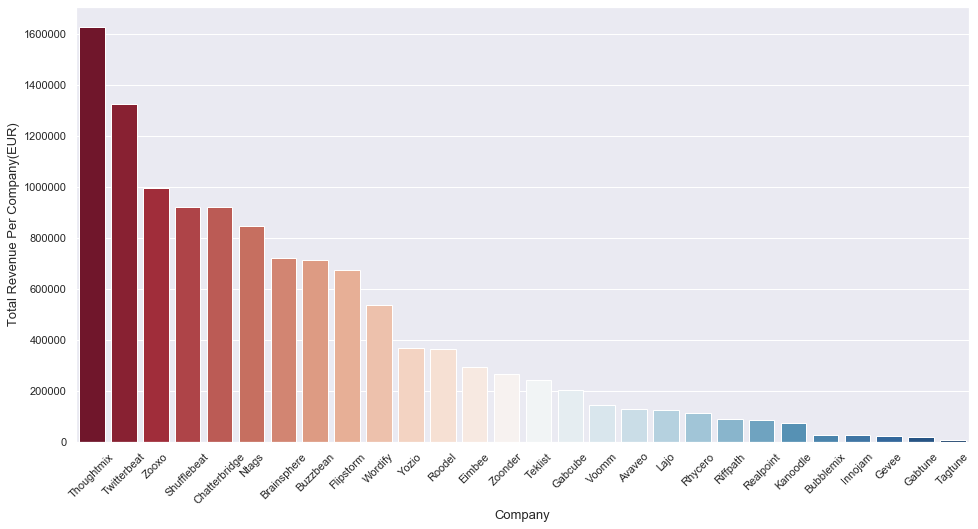

In [96]:
sns.set(rc={'figure.figsize':(16,8)})
plot = sns.barplot(x='company', y='total_revenue', palette="RdBu", data=data_company)
plt.xticks(rotation=45)
plt.xlabel('Company', fontsize=13)
plt.ylabel('Total Revenue Per Company(EUR)', fontsize=13)
plt.show()

From the plot, we can clearly see the most profitable companies. Top three are `Thoughtmix`, `Twitterbeat` and `Zooxo`. The company shall keep a strong touch with them to maintaine the close cooperation.

---

**Solution 2:**

Select the total revenue in year 2016

In [97]:
c.execute("SELECT company, (SUM(price_eur)) FROM transactions WHERE date BETWEEN '2016-01-01' AND '2016-12-31' GROUP BY company ORDER BY company")
data_2016 = pd.DataFrame((c.fetchall()), columns=['company', 'revenue_2016'])
# data_2016

Select the total revenue in year 2017

In [98]:
c.execute("SELECT company, (SUM(price_eur)) FROM transactions WHERE date BETWEEN '2017-01-01' AND '2017-12-31' GROUP BY company ORDER BY company")
data_2017 = pd.DataFrame((c.fetchall()), columns=['company', 'revenue_2017'])
# data_2017

Select the total revenue in year 2018

In [99]:
c.execute("SELECT company, (SUM(price_eur)) FROM transactions WHERE date BETWEEN '2018-01-01' AND '2018-12-31' GROUP BY company ORDER BY company")
data_2018 = pd.DataFrame((c.fetchall()), columns=['company', 'revenue_2018'])
# data_2018

Visualize the proportion of revenue in 2016, 2017, 2018. The observations in year 2019 is inadequate to analysis. Therefore, it shall not be included.

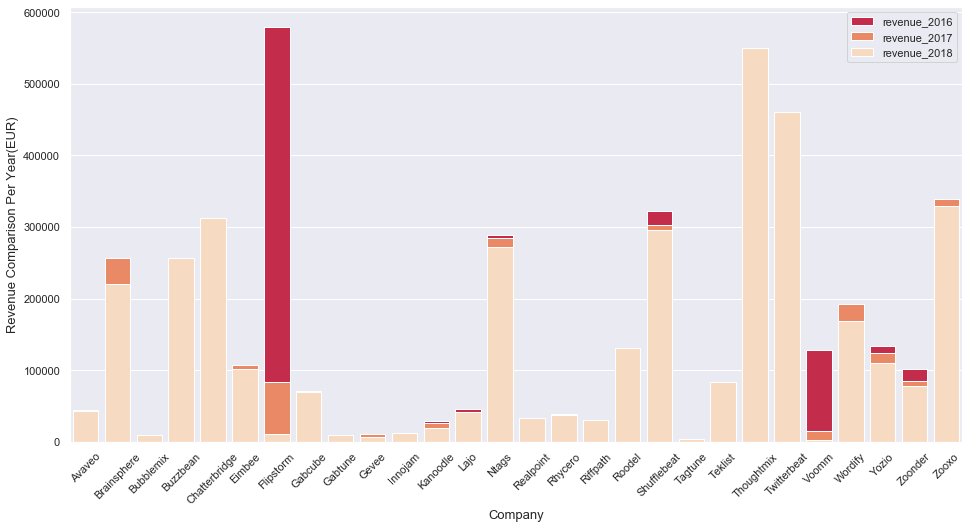

In [100]:
sns.set(rc={'figure.figsize':(16,8)})
ax1 = sns.barplot(x='company', y='revenue_2016', color='crimson', data=data_2016, label = 'revenue_2016')
ax2 = sns.barplot(x='company', y='revenue_2017', color='coral', data=data_2017, ax=ax1, label = 'revenue_2017')
plot = sns.barplot(x='company', y='revenue_2018', color='peachpuff', data=data_2018, ax=ax2, label = 'revenue_2018')
plt.xticks(rotation=45)
plt.xlabel('Company', fontsize=13)
plt.ylabel('Revenue Comparison Per Year(EUR)', fontsize=13)
plt.legend()
plt.show()

From 2016 to 2019, we represent revenue for those years from deep color to shallow to enhance the contarst. Therefore, it is obvious to see that `Flipstorm` and `Voomm` are potential churn clients since they both generate much less revenue through this period. Others who have some slight decline could be assumed as normal market turbulence.

---

**Solution 3:**

Calculate the total revenue of each country and sort in descending order.

In [101]:
c.execute("SELECT mysum, mycountry FROM (SELECT SUM(price_eur) AS mysum, country as mycountry FROM transactions GROUP BY mycountry) ORDER BY mysum DESC")
data_country = pd.DataFrame(c.fetchall(), columns=['total_revenue', 'country'])
# data_country

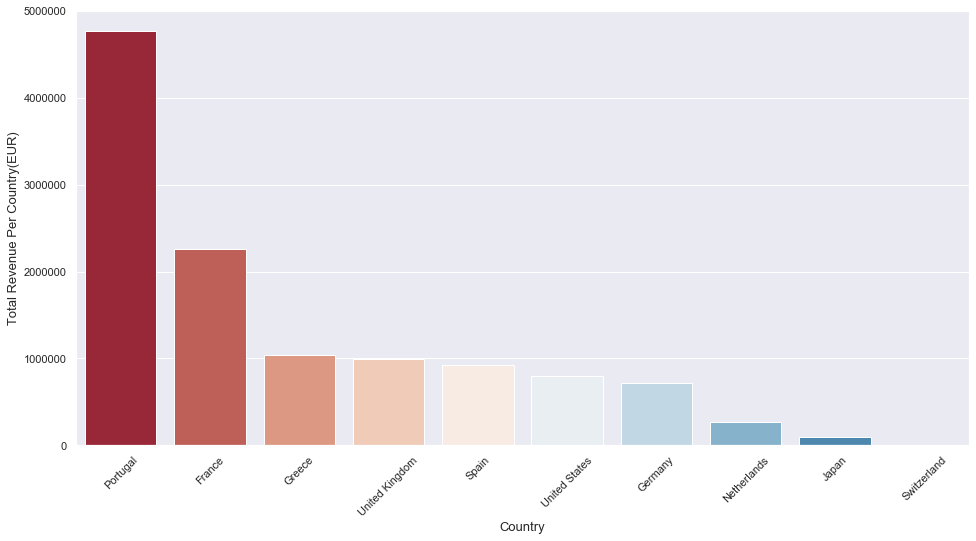

In [102]:
sns.set(rc={'figure.figsize':(16,8)})
plot = sns.barplot(x='country', y='total_revenue', palette="RdBu", data=data_country)
plt.xticks(rotation=45)
plt.xlabel('Country', fontsize=13)
plt.ylabel('Total Revenue Per Country(EUR)', fontsize=13)
plt.show()

`Portugal` and `France` contribute most revenue for company X, this result can be an indicator for boss to consider to promote the collaboration with companies from these two countrys with some incentives in future.

---

**solution 4:**

Calculate the total revenue of each city and sort in descending order.

In [103]:
c.execute("SELECT mysum, mycity FROM (SELECT SUM(price_eur) AS mysum, city as mycity FROM transactions GROUP BY mycity) ORDER BY mysum DESC")
data_city = pd.DataFrame(c.fetchall(), columns=['total_revenue', 'city'])
# data_country

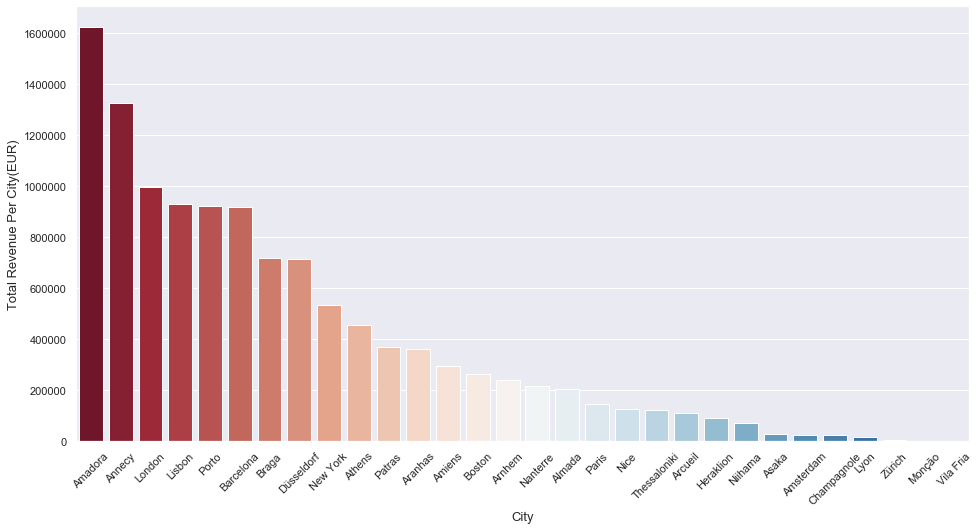

In [104]:
sns.set(rc={'figure.figsize':(16,8)})
plot = sns.barplot(x='city', y='total_revenue', palette="RdBu", data=data_city)
plt.xticks(rotation=45)
plt.xlabel('City', fontsize=13)
plt.ylabel('Total Revenue Per City(EUR)', fontsize=13)
plt.show()

`Amadora`, `Annecy` and `London` contribute top 3 revenue for company X, this result motivates the boss to consider to promote the experience of local sales and technical team to other cities and extract the key elements of successful business.


---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

**Solution1:**

In [105]:
def query_interval(t1, t2):
    '''
    input: t1, t2, a date interval
    output: transaction records in time interval t1, t2
    '''
    c.execute("SELECT * FROM transactions WHERE date BETWEEN ? AND ?",(t1, t2))
    data = c.fetchall()
    return data

In [106]:
# Example:
# Measure the time we need for querying data of one year
%timeit data = query_interval("2016-01-01", "2016-12-31")
# pd.DataFrame(data)

42 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We need only around 0.02 seconds for querying one-year data, which is quite fast compare to other ways accessing data. 

---

**Solution2:**

In [107]:
def query_latest(num):
    '''
    input: num, how many records do you want to see.
    output: the queried records.
    '''
    c.execute("SELECT * FROM transactions ORDER BY datetime DESC")
    data = c.fetchmany(num)
    return data

In [108]:
# Example:
%timeit data = pd.DataFrame(query_latest(10000))
# pd.DataFrame(data)

83.5 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Within 0.05 seconds, the latest 10000 sales are shown, which is still reasonable and swift.

---

**Solution3:**

In [109]:
def sales_company_day():
    '''
    output: show the total transaction amount for each company each day
    '''
    c.execute("SELECT date, company, SUM(price_eur) FROM transactions GROUP BY date, company")
    data = c.fetchall()
    return data

In [110]:
%timeit data = pd.DataFrame(sales_company_day())
# pd.DataFrame(data)

65.2 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
c.close()

Similar as before, the query is done using multiple `ms`. Therefore, we can draw the conclusion that applying the functions above (virtually using SQLite queries) allow us to read, retrieve, delete or do many other operations on large-salce data very fast. 